# Data Loading and Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import pickle 

In [3]:
data_dir = './data/'

In [4]:
results_dir = './data/results/'

In [5]:
models_dir = './models/'

In [6]:
model_name = 'support_vector_classification'

In [7]:
classification_data = pd.read_csv(data_dir+'classification_data.csv', index_col=[0])

# SVM (Classification)

In [8]:
classification_data

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,1,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,brown,1,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,unknown,smooth,silky,white,1,evanescent,white,several,leaves


In [9]:
classification_data.shape

(8124, 20)

In [10]:
dep_var = 'edible'

In [11]:
X = classification_data.iloc[:,classification_data.columns != dep_var]

In [12]:
y = classification_data[dep_var]

In [13]:
y

0       poisonous
1          edible
2          edible
3       poisonous
4          edible
          ...    
8119       edible
8120       edible
8121       edible
8122    poisonous
8123       edible
Name: edible, Length: 8124, dtype: object

In [14]:
# Random 6-digit seed
test_seed = 513370

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=test_seed, stratify=y)

Initialise the dataframe that holds the results of the datasets

In [16]:
columns = ['task', 'model', 'seed', 'split', 'C', 'kernel', 'gamma', 'shrinking', 'train_accuracy', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1_score', 'valid_auroc']
support_vector_classification_results_df = pd.DataFrame(columns=columns)
df_rows = 0

In [17]:
# 5 random 6 digit numbers
seeds = [660108, 720389, 193768, 586930, 327407]

Now we need to prepare our data and the cross-validation process so that we can start training.

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
for seed in seeds:
    print(f'Starting training for seed {seed}')
    # assign the tuned parameters
    split = 0
    Cs = [c/10 for c in range(1,11, 2)]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    gammas = [0.1, 1, 10]
    shrinkings = [True, False]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
    for train_index, valid_index in KFold(n_splits=5, shuffle=False).split(X_train):
        # Data Split
        split += 1
        X_train_curr_split = X_train.iloc[train_index]
        X_valid_curr_split = X_train.iloc[valid_index]
        y_train_curr_split = y_train.iloc[train_index]
        y_valid_curr_split = y_train.iloc[valid_index]
       
        # Avoiding data leakage for input values
        enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
        X_train_curr_split = enc.fit_transform(X_train_curr_split)
        X_valid_curr_split = enc.transform(X_valid_curr_split)
        
        # as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
        encoder_dict = {'edible': 1,
                        'poisonous': 0}
        # transform the output into the right format
        y_train_curr_split = y_train_curr_split.replace(encoder_dict).values.flatten()
        y_valid_curr_split = y_valid_curr_split.replace(encoder_dict).values.flatten()
        for C in Cs:
            for kernel in kernels:
                for gamma in gammas:
                    for shrinking in shrinkings:
                        pipe = make_pipeline(
#                             preprocessing.StandardScaler(), 
                                             SVC(C=C,
                                                 kernel=kernel,
                                                 gamma=gamma,
                                                 shrinking=shrinking,
                                                 random_state=seed
                                                )
                                            )
                        # train the model
                        pipe.fit(X_train_curr_split, y_train_curr_split) 
                        # Obtain metric scores
                        valid_predictions = pipe.predict(X_valid_curr_split)
                        valid_prec_score = precision_score(y_valid_curr_split, valid_predictions)
                        valid_rec_score = recall_score(y_valid_curr_split, valid_predictions)
                        valid_f1_score = f1_score(y_valid_curr_split, valid_predictions)
                        fpr, tpr, threshold = roc_curve(y_valid_curr_split, valid_predictions)
                        valid_auroc = auc(fpr, tpr)
                        valid_accuracy = pipe.score(X_valid_curr_split, y_valid_curr_split)
                        train_accuracy = pipe.score(X_train_curr_split, y_train_curr_split)
                        support_vector_classification_results_df.loc[df_rows] = ['classification', 
                                                                                 'SVC', 
                                                                                 seed,
                                                                                 split,
                                                                                 C,
                                                                                 kernel,
                                                                                 gamma,
                                                                                 shrinking,
                                                                                 train_accuracy,
                                                                                 valid_accuracy,
                                                                                 valid_prec_score,
                                                                                 valid_rec_score,
                                                                                 valid_f1_score,
                                                                                 valid_auroc]
                        # increment the rows variable
                        df_rows +=1
    print(f'Done training for seed {seed}')     

## Functions

In [23]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [24]:
support_vector_classification_results_df

,task,model,seed,split,C,kernel,gamma,shrinking,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,classification,SVC,660108,1,0.1,linear,0.1,True,0.955761,0.957692,0.986301,0.933718,0.959289,0.959433
1,classification,SVC,660108,1,0.1,linear,0.1,False,0.955761,0.957692,0.986301,0.933718,0.959289,0.959433
2,classification,SVC,660108,1,0.1,linear,1.0,True,0.955761,0.957692,0.986301,0.933718,0.959289,0.959433
3,classification,SVC,660108,1,0.1,linear,1.0,False,0.955761,0.957692,0.986301,0.933718,0.959289,0.959433
4,classification,SVC,660108,1,0.1,linear,10.0,True,0.955761,0.957692,0.986301,0.933718,0.959289,0.959433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,classification,SVC,327407,5,0.9,sigmoid,0.1,False,0.491346,0.523480,0.536254,0.532234,0.534236,0.523237
2996,classification,SVC,327407,5,0.9,sigmoid,1.0,True,0.441346,0.418014,0.432881,0.430285,0.431579,0.417674
2997,classification,SVC,327407,5,0.9,sigmoid,1.0,False,0.441346,0.418014,0.432881,0.430285,0.431579,0.417674
2998,classification,SVC,327407,5,0.9,sigmoid,10.0,True,0.491538,0.470362,0.484305,0.485757,0.485030,0.469936


In [25]:
support_vector_classification_results_df.to_csv(results_dir + 'support_vector_classification_results_df.csv')

Aggregate the values so that we average the results for each random seed

In [26]:
grouped_support_vector_classification_results_df = group_seeded_data(support_vector_classification_results_df, 
                                                                     ['C', 'kernel', 'gamma', 'shrinking']
                                                                    )

In [27]:
grouped_support_vector_classification_results_df

,C,kernel,gamma,shrinking,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,0.1,linear,0.1,False,0.964256,0.962887,0.986282,0.941418,0.963283,0.963699
1,0.1,linear,0.1,True,0.964271,0.962918,0.986346,0.941418,0.963313,0.963730
2,0.1,linear,1.0,False,0.964256,0.962887,0.986282,0.941418,0.963283,0.963699
3,0.1,linear,1.0,True,0.964271,0.962918,0.986346,0.941418,0.963313,0.963730
4,0.1,linear,10.0,False,0.964256,0.962887,0.986282,0.941418,0.963283,0.963699
...,...,...,...,...,...,...,...,...,...,...
115,0.9,sigmoid,0.1,True,0.494630,0.495339,0.512988,0.509935,0.511311,0.494796
116,0.9,sigmoid,1.0,False,0.439398,0.440098,0.459459,0.459564,0.459314,0.439456
117,0.9,sigmoid,1.0,True,0.439475,0.440006,0.459393,0.459797,0.459399,0.439350
118,0.9,sigmoid,10.0,False,0.494922,0.495675,0.513401,0.511485,0.512183,0.495288


In [28]:
grouped_support_vector_classification_results_df.to_csv(results_dir + 'grouped_support_vector_classification_results_df.csv')

## Functions

In [29]:
def plot_line(data, x_column='C', groupby_column = 'kernel', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    grouped_data = data.groupby([groupby_column, x_column]).agg(acc=(acc, 'mean')).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [25]:
def plot_conf_matrix(y_test, test_predictions, tick_size=12):
    conf_matrix = confusion_matrix(y_test, test_predictions)
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True,linewidths=0.5,linecolor="red", fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size, labelrotation=90)
    plt.show()

## Overal results demonstration

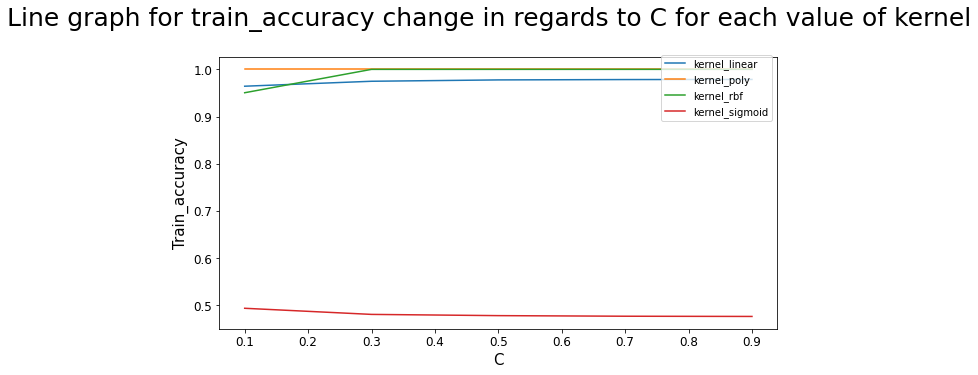

In [31]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='kernel', acc='train_accuracy')

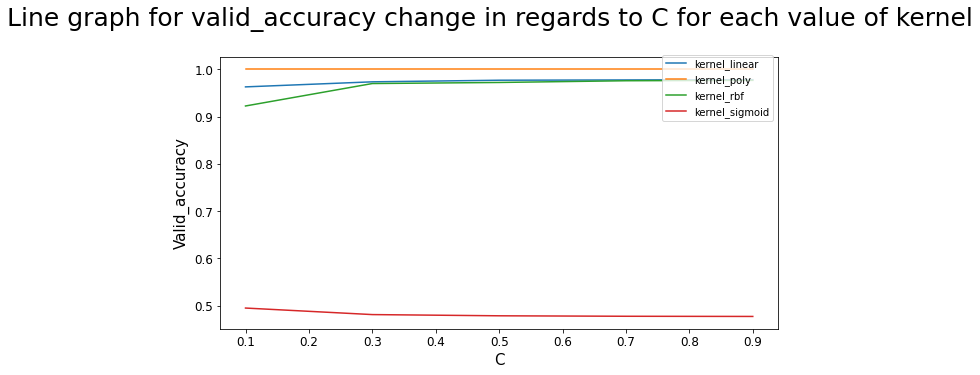

In [32]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='kernel', acc='valid_accuracy')

It seems that no model overfitted on the data as train and validation accuraccy is simillar in regards to the kernel.

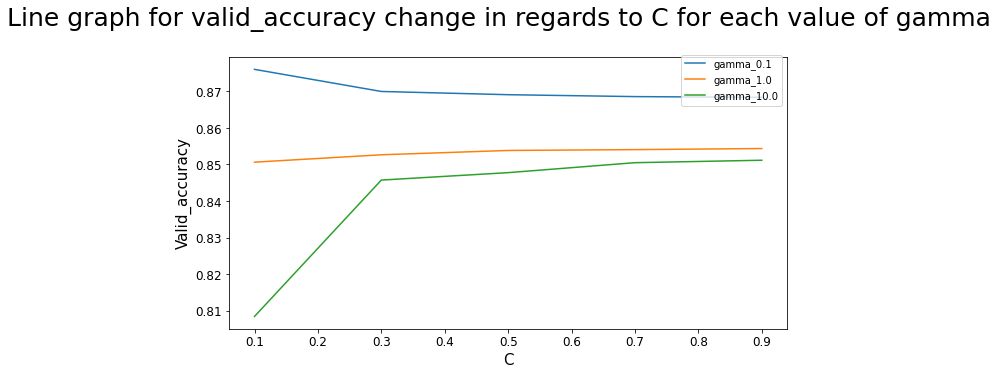

In [33]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='gamma', acc='valid_accuracy')

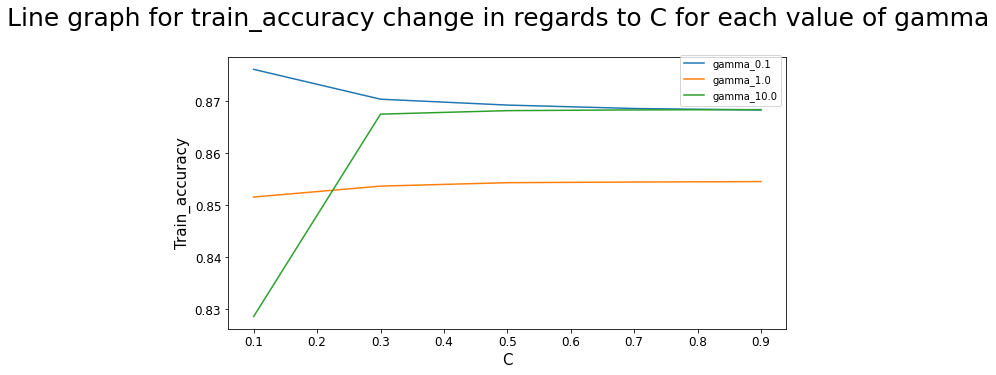

In [34]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='gamma', acc='train_accuracy')

In regards to gamma value, it seems that the models that use 10, overfit on the training set, whereas the rest of the models do not.

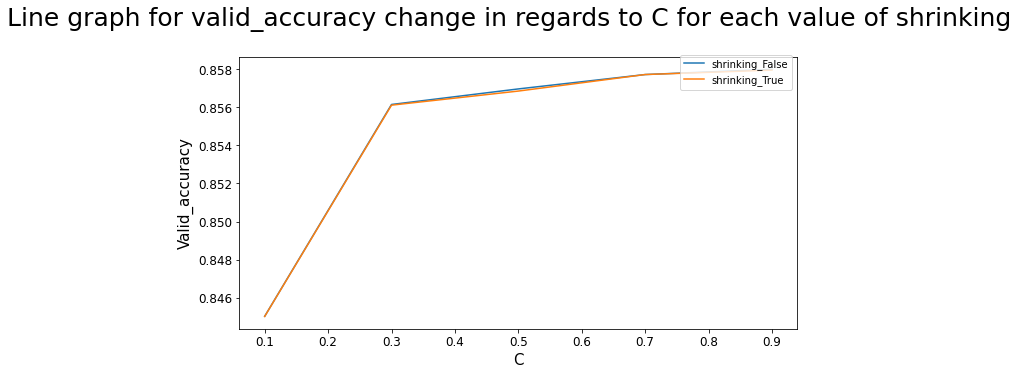

In [35]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='shrinking', acc='valid_accuracy')

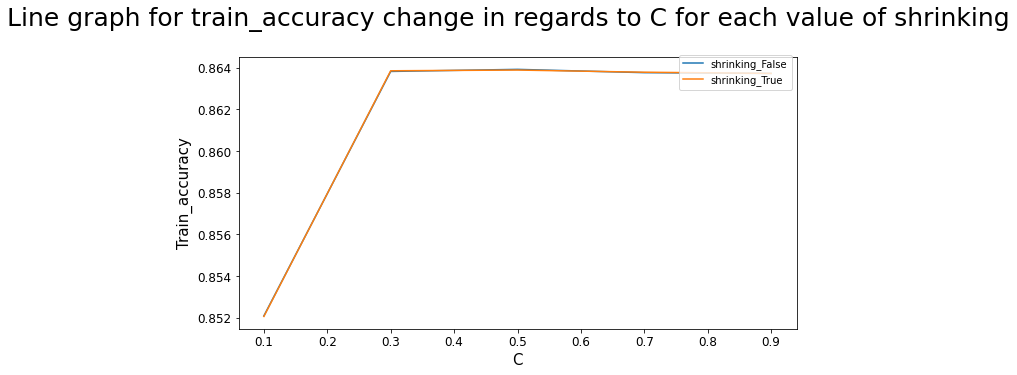

In [36]:
plot_line(grouped_support_vector_classification_results_df, groupby_column='shrinking', acc='train_accuracy')

Moreover, shrinking the data seemed to have no effect on the models' accuracy.

As it was made clear in the EDA in the other notebook, data is distributed equally, therefore all of the above metrics are good model evaluators. However, when we are dealing with edible and poisonous mushrooms it is important to not mistake a poisonous for an edible mushroom (the opposite is not that important), therefore precision is the most important metric.

In [37]:
grouped_support_vector_classification_results_df[grouped_support_vector_classification_results_df['valid_precision'] == grouped_support_vector_classification_results_df['valid_precision'].max()]

,C,kernel,gamma,shrinking,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
6,0.1,poly,0.1,False,1.0,1.0,1.0,1.0,1.0,1.0
7,0.1,poly,0.1,True,1.0,1.0,1.0,1.0,1.0,1.0
8,0.1,poly,1.0,False,1.0,1.0,1.0,1.0,1.0,1.0
9,0.1,poly,1.0,True,1.0,1.0,1.0,1.0,1.0,1.0
10,0.1,poly,10.0,False,1.0,1.0,1.0,1.0,1.0,1.0
11,0.1,poly,10.0,True,1.0,1.0,1.0,1.0,1.0,1.0
30,0.3,poly,0.1,False,1.0,1.0,1.0,1.0,1.0,1.0
31,0.3,poly,0.1,True,1.0,1.0,1.0,1.0,1.0,1.0
32,0.3,poly,1.0,False,1.0,1.0,1.0,1.0,1.0,1.0
33,0.3,poly,1.0,True,1.0,1.0,1.0,1.0,1.0,1.0


There are some models that predicted the test and valid data perfectly, therefore the best model for the test data will use any of those configurations.

In [16]:
model = SVC(C=0.1,
            kernel = 'poly',
            gamma=0.1,
            random_state=test_seed,
            probability=True
           )
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)

best_pipe = make_pipeline(enc,
#                           preprocessing.StandardScaler(),
                          model
                         ) 

In [17]:
best_pipe = best_pipe.fit(X_train, y_train) 

In [18]:
test_predictions = best_pipe.predict(X_test)
encoder_dict = {'edible': 1,
                'poisonous': 0}
# transform the output into the right format
y_train_enc = y_train.replace(encoder_dict).values.flatten()
y_test_enc = y_test.replace(encoder_dict).values.flatten()
test_predictions[test_predictions == 'edible'] = 1
test_predictions[test_predictions == 'poisonous'] = 0
test_predictions = test_predictions.astype('int16')
test_prec_score = precision_score(y_test_enc, test_predictions)
test_rec_score = recall_score(y_test_enc, test_predictions)
test_f1_score = f1_score(y_test_enc, test_predictions)
fpr, tpr, threshold = roc_curve(y_test_enc, test_predictions)
test_auroc = auc(fpr, tpr)
test_accuracy = best_pipe.score(X_test, y_test)
train_accuracy = best_pipe.score(X_train, y_train)

# Obtain metric scores

### Results on test set

In [19]:
print(f"The predicion score on the test set for the best model is {test_prec_score.round(3)} \n")

The predicion score on the test set for the best model is 1.0 



In [20]:
print(f"The recall score on the test set for the best model is {test_rec_score.round(3)} \n")

The recall score on the test set for the best model is 1.0 



In [21]:
print(f"The f1-score on the test set for the best model is {test_f1_score.round(3)} \n")

The f1-score on the test set for the best model is 1.0 



In [22]:
print(f"The auroc score on the test set for the best model is {test_auroc.round(3)} \n")

The auroc score on the test set for the best model is 1.0 



In [23]:
print(f"The accuracy on the test set for the best model is {test_accuracy.round(3)} \n")

The accuracy on the test set for the best model is 1.0 



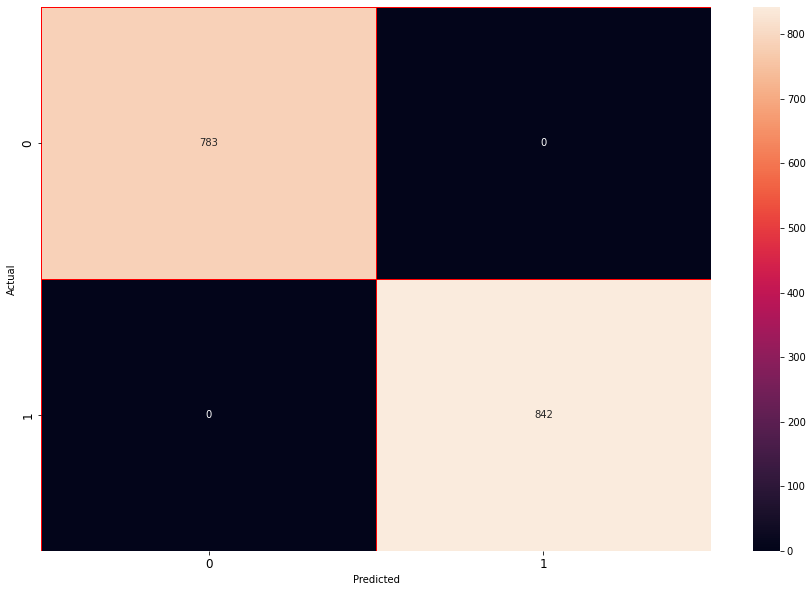

In [26]:
plot_conf_matrix(y_test_enc, test_predictions)

Save the model on disc

In [27]:
model_name = 'support_vector_classification'

In [28]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [ ]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))